In [3]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import experiments.MERA.modified_binary_mera as mod_bm
import experiments.MERA.binary_mera as bm
import experiments.MERA.binary_mera_lib as bml
import experiments.MERA.misc_mera 

import pickle
import time
import datetime
from sys import stdout
import tensornetwork.ncon_interface as ncon
import tensornetwork as tn
from lib.ncon import ncon as ncon_np
import matplotlib.pyplot as plt

#tf.enable_eager_execution()
tf.enable_v2_behavior()
tf.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.13.1'

# binary MERA
A scale-invariant binary MERA is a tensor network of the following form:
![title](MERA.png)

The blue triangles are called isometries, and the green squares are called disentanglers.
The microscopic degrees of freedom $i_n$ are at the bottom of the network.
The following cell initializes a scale invariant binary MERA. 
Below `wC` is a list of `tf.Tensor` containing isometries in layers $\tau$, 
and `uC` is a list of `tf.Tensor` with the disentanglers
in layer $\tau$. 

The following cell performs a simple check: it calculates the expectatio value
of the local Hamiltonian in each layer. The values should increase as $2^{\tau}$.


In [18]:
def test_ascending_descending(chi=4,dtype = tf.float64):
    import copy
    wC, uC, rho_0 = bml.initialize_binary_MERA_identities(phys_dim=2, chi=4, dtype=dtype)
    for n in range(5):
        wC.append(copy.copy(wC[-1]))
        uC.append(copy.copy(uC[-1]))
    wC, uC,_,_ = bm.run_binary_mera_optimization_TFI(chis=[chi], niters=[10],opt_u_after=0 ,
                                                       embeddings=['a'], dtype=dtype,
                                                       wC=wC, uC=uC)
    ham_0 = bml.initialize_TFI_hams(dtype)
    rho = [0 for n in range(len(wC)+1)]
    ham = [0 for n in range(len(wC)+1)]
    rho[-1] = bml.steady_state_density_matrix(10, rho_0, wC[-1], uC[-1])
    ham[0]= ham_0
    print()
    for p in range(len(rho)-2,-1,-1):
        rho[p] = bml.descending_super_operator(rho[p+1], wC[p], uC[p])
    for p in range(len(wC)):
        ham[p+1] = bml.ascending_super_operator(ham[p], wC[p], uC[p])
    energies = [ncon.ncon([rho[p],ham[p]],[[1, 2, 3, 4, 5, 6],[1, 2, 3, 4, 5, 6]]) for p in range(len(rho))]
    print('following numbers should all be 1/2')
    print(np.array([energies[p]/energies[p+1] for p in range(len(energies) -1 )]))
test_ascending_descending()    

     Iteration: 1 of 10: E = -0.85752282, err = 0.4157167217999074 at D = 4 with 8 layers
following numbers should all be 1/2
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


## optimize 
The following cell runs an optimization to approximate the 
ground state of the transverse field Ising model with a MERA. 
The method returns list `uC` and `wC` of `tf.Tensor` objects, 
the disentanglers and the isometries, respectively.

In [22]:
wC, uC,_,_ = bm.run_binary_mera_optimization_TFI(chis=[4,4], niters=[1000,400], 
                                                 embeddings=['a','a'], dtype=dtype, opt_u_after=40,
                                                 opt_all_layers=[True, True], nsteps_steady_state=12)


     Iteration: 391 of 400: E = -1.27323714, err = 0.0000024014674909 at D = 4 with 3 layerss

we can pass the tensors in `wC` and `uC` again to the routine to resume optimization

In [51]:
wC, uC,_,_ = bm.run_binary_mera_optimization_TFI(chis=[6], niters=[50], 
                                                 embeddings=['p'], dtype=dtype,opt_u_after=0,
                                                 opt_all_layers=[True], nsteps_steady_state=12,
                                                 wC=wC, uC=uC)

     Iteration: 41 of 50: E = -1.27323896, err = 0.0000005802005301 at D = 6 with 5 layers

## Scaling dimensions
From the optimized MERA, we can calculate scaling dimensions of the Ising CFT by diagonalizing
the scale-invariant ascending super-operator:

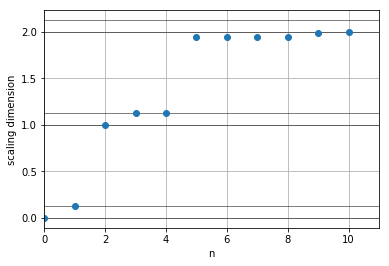

[-2.2423985526704407e-15, 0.124975948130524, 1.000333634595263, 1.1238516556121871, 1.1253651761944474, 1.9437282753903449, 1.9437282753903449, 1.9437894279856556, 1.9437894279856556, 1.9874814169212434, 1.998551443341432]


In [52]:
k=11
scdims = sorted(bml.get_scaling_dimensions(wC[-1], uC[-1], k=k))

    

%matplotlib inline
plt.plot(range(len(scdims)),scdims,'o')
plt.grid()
plt.hlines(0.0,-2,12,linewidth=0.5)
plt.hlines(0.125,-2,12,linewidth=0.5)
plt.hlines(1.0,-2,12,linewidth=0.5)
plt.hlines(1.125,-2,12,linewidth=0.5)
plt.hlines(2,-2,12,linewidth=0.5)
plt.hlines(2.125,-2,12,linewidth=0.5)
plt.xlim([0,k])
plt.xlabel('n')
plt.ylabel('scaling dimension')
plt.draw()
plt.show()
print(scdims)

# modified binary MERA
the modified binary MERA is a simplified version of the binary MERA.  See webpage below:

In [60]:
import IPython
url = 'https://www.tensors.net/p-mera'
iframe = '<iframe src=' + url + ' width=950 height=1000></iframe>'
IPython.display.HTML(iframe)

## optimize modified binary MERA

In [71]:
#run a modified binary mera optimization for the TFI model
energies, walltimes, wC, vV, uC = mod_bm.run_mod_binary_mera_optimization_TFI(chis=[4,6], niters=[1000, 1000], 
                                                                              embeddings=['p','a'],
                                                                              dtype=tf.float64, verbose=1, 
                                                                              nsteps_steady_state=8,refsym=True)


Iteration: 991 of 1000: E = -1.27322090, err = 0.0000186485689615 at D = 6 with 2 layers

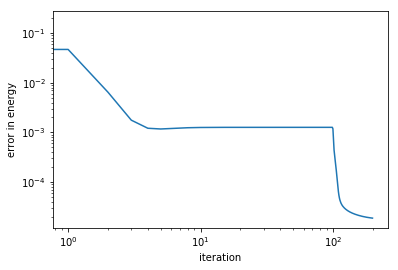

In [72]:
plt.loglog(np.array(energies)+4/np.pi)
plt.xlabel('iteration')
plt.ylabel('error in energy')
plt.draw()
plt.show()